In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
import os
import time
from glob import glob

pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
"""
set_configuration : Argument setting 하는 함수
get_webtoon_titleId : 웹툰명으로 타이틀id를 구하는 함수
get_num_pages : 에피소드별 댓글 페이지 개수를 구하는 함수
get_num_episodes : 웹툰의 에피소드 개수를 구하는 함수
get_comments : 에피소드의 댓글을 수집하는 함수

get_all_comments : 모든 에피소드의 댓글을 수집하는 함수

merge_csv_files : 에피소드별 댓글 CSV 파일을 통합하는 함수

get_point_participants : 에피소드별 별점과 참여자수를 구하는 함수
get_num_reviews : 에피소드별 댓글 개수를 구하는 함수

get_top10_point_participants : 에피소드별 별점과 참여자수가 가장 높은 에피소드 top10을 반환하는 함수

"""

'\nset_configuration : Argument setting 하는 함수\nget_webtoon_titleId : 웹툰명으로 타이틀id를 구하는 함수\nget_num_pages : 에피소드별 댓글 페이지 개수를 구하는 함수\nget_num_episodes : 웹툰의 에피소드 개수를 구하는 함수\nget_comments : 에피소드의 댓글을 수집하는 함수\n\nget_all_comments : 모든 에피소드의 댓글을 수집하는 함수\n\nmerge_csv_files : 에피소드별 댓글 CSV 파일을 통합하는 함수\n\nget_point_participants : 에피소드별 별점과 참여자수를 구하는 함수\nget_num_reviews : 에피소드별 댓글 개수를 구하는 함수\n\nget_top10_point_participants : 에피소드별 별점과 참여자수가 가장 높은 에피소드 top10을 반환하는 함수\n\n'

In [3]:
def get_webtoon_titleId(chromedriver_path, platform, lang, titleName):
    """
    웹툰명으로 타이틀id를 구하는 함수
    """
    if lang == 'kr':
        print(titleName,"의 titleId를 구합니다.")
    elif lang == 'en':
        print("Get the title number of the ", titleName)
        
    # chrome driver setting    
    service = Service(executable_path=chromedriver_path)

    TIMEOUT = 1 
    driver = webdriver.Chrome(service=service)  
    
    if platform == 'naver' and lang == 'kr':
        base_url = 'https://comic.naver.com/index' 
    elif platform == 'naver' and lang == 'en':
        base_url = 'https://www.webtoons.com/en/' 
        
    print(base_url)
    driver.get(base_url)
    driver.implicitly_wait(TIMEOUT)   
    
    search_query = titleName

    if lang == 'kr':
        # https://comic.naver.com/search?keyword=전지적+독자+시점
        driver.find_element(by=By.CSS_SELECTOR, value='input#gnb\.keyword').clear() # 검색창 초기화
        driver.find_element(by=By.CSS_SELECTOR, value='input#gnb\.keyword').send_keys(search_query)  # 검색어 입력 
        driver.find_element(by=By.CSS_SELECTOR, value= '#search_bar_button > span').click()  # 검색 버튼 클릭
        time.sleep(1)        
        
        # 웹툰 선택
        driver.find_element(by=By.CSS_SELECTOR, value='#content > div.searchTxt > ul > li:nth-child(2) > a').click()
        time.sleep(1)  

        names = driver.find_elements(by=By.CSS_SELECTOR, value='#content ul h5 > a')
        for name in names:
            if name.text == titleName:
                href = name.get_attribute('href')
                titleId = href.split('?titleId=')[1]
                print(titleName, 'titleId ', titleId)
            
    elif lang == 'en':
        # https://www.webtoons.com/en/search?keyword=Omniscient%20Reader
        driver.find_element(by=By.CSS_SELECTOR, value= 'a.btn_search').click()  # 검색 버튼 클릭
        driver.find_element(by=By.CSS_SELECTOR, value='input.input_search').clear() # 검색창 초기화
        driver.find_element(by=By.CSS_SELECTOR, value='input.input_search').send_keys(search_query)  # 검색어 입력
        driver.find_element(by=By.CSS_SELECTOR, value='input.input_search').send_keys(Keys.RETURN)  # Enter Key 입력 
              
        # ORIGINALS 선택
        names = driver.find_elements(by=By.CSS_SELECTOR, value='#content > div.card_wrap.search._searchResult > ul > li > a')
        time.sleep(1) 
        # CANVAS 선택
        #elements = driver.find_elements(by=By.CSS_SELECTOR, value='#content > div.card_wrap.search._searchResult > div.challenge_lst.search > ul  a > p.subj')
        for name in names:
            subj = name.find_element(by=By.CSS_SELECTOR, value='div > p.subj')
            if subj.text == titleName:
                href = name.get_attribute('href')
                titleId = href.split('?titleNo=')[1]
                print(titleName, 'titleId ', titleId)   
    driver.quit()
    return titleId

In [4]:
def get_num_episodes(chromedriver_path, platform = 'naver', lang = 'kr', titleId = 747269):
    """
    웹툰의 에피소드 개수를 구하는 함수
    """    
    if lang == 'kr':
        print('titleId가 ', titleId, "인 웹툰의 episode 개수를 구합니다.")
    elif lang == 'en':
        print("Get the number of episodes of titleId, ", titleId)
        
    # chrome driver setting    
    service = Service(executable_path=chromedriver_path)    
    TIMEOUT = 1 
    driver = webdriver.Chrome(service=service)
    
    if platform == 'naver' and lang == 'kr':
        base_url = 'https://comic.naver.com/webtoon/list?' + 'titleId=' + str(titleId)
    elif platform == 'naver' and lang == 'en':    
        base_url = 'https://www.webtoons.com/en/action/omniscient-reader/list?' + 'title_no=' + str(titleId)
        
    print(base_url)
    driver.get(base_url)
    driver.implicitly_wait(TIMEOUT)   
       
    # Get the total number of pages
    if lang == 'kr':
        pages = driver.find_element(by=By.CSS_SELECTOR, value="#content > table > tbody > tr:nth-child(2) > td.title > a")
        num_episodes = int(pages.text.split('.')[0]) + 1
        print("num_episodes:", num_episodes)
    elif lang == 'en':  
        element = driver.find_element(by=By.CSS_SELECTOR, value="li._episodeItem")
        num_episodes = int(element.get_attribute("data-episode-no"))
        print("num_episodes:", num_episodes)
        
    driver.quit()
    return num_episodes

In [5]:
def get_comments(driver, df, lang = 'kr', titleId = 747269, episode_no = 1):
    """
    에피소드의 댓글을 수집하는 함수
    """        
    
    if lang == 'kr':
        base_url = 'https://comic.naver.com/webtoon/detail?'
        episode_url = base_url + 'titleId=' + str(titleId) + '&no='+str(episode_no)
    elif lang == 'en':
        # https://www.webtoons.com/en/action/omniscient-reader/episode-118/viewer?title_no=2154&episode_no=119
        base_url = 'https://www.webtoons.com/en/action/omniscient-reader/episode-'
        episode_url = base_url + str(episode_no -1) + '/viewer?title_no=' + str(titleId) + '&episode_no='+str(episode_no)        
        
    print(episode_url)
    driver.get(episode_url)
    driver.implicitly_wait(1)
    
    if lang == 'kr':
        # 댓글창에 해당하는 프레임 선택
        driver.switch_to.frame('commentIframe')

        # 수집 편의를 위한 클린봇 댓글 필터링 기능 해제
        # (클린봇이 부적절한 표현을 감지한 댓글입니다.) 제거
        driver.find_element(By.CLASS_NAME,'u_cbox_cleanbot_setbutton').click()
        time.sleep(0.2)
        driver.find_element(By.CLASS_NAME,'u_cbox_layer_cleanbot2_checkbox').click()
        time.sleep(0.2)
        driver.find_element(By.CLASS_NAME,'u_cbox_layer_cleanbot2_extrabtn').click()
        time.sleep(0.2)

        # 전체 댓글 클릭
        driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_view_comment > a').click()
        time.sleep(0.5)        
    elif lang == 'en':
        # No iframe
        # No Cleanbot filtering setting
        # No need to click "전체 댓글"        
        pass 
    
    # Move to the last page and Get the total number of pages
    driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_paginate > div > a.u_cbox_next.u_cbox_next_end').click()
    time.sleep(1)
    
    u_cbox_num_page = driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_paginate > div > strong > span.u_cbox_num_page')
    time.sleep(1)
    num_pages = u_cbox_num_page.text
    print("num_pages:",num_pages)
  
    # Move to the first page
    driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_paginate > div > a.u_cbox_pre.u_cbox_pre_end').click()
    time.sleep(0.5)

    for page in range(int(num_pages)):
        if lang == 'kr':        
            # switch to the recent tab
            driver.switch_to.window(driver.window_handles[-1]) 
            driver.switch_to.frame("commentIframe")        
        
        soup = bs(driver.page_source,"html.parser")

        # Extract dates
        dates = soup.findAll("span", {"class":["u_cbox_date"]})
        dates = [date.text for date in dates]        

        # Extract reveiws
        reviews = soup.findAll("span", {"class":["u_cbox_contents"]})
        reviews = [review.get_text() for review in reviews]

        df_page = pd.DataFrame(data=[], columns=['Episode','Date','Review'])       
        df_page['Date'] = dates
        df_page['Review'] = reviews
        df_page['Episode'] = df_page['Episode'].fillna(int(episode_no))
        
        df = pd.concat([df,df_page])      
        print('.', end='')

        if (page+1) == int(num_pages):
            return df
        
        # Move to the next page
        driver.find_element(By.CSS_SELECTOR, "#cbox_module > div > div.u_cbox_paginate > div > strong + a").click()        
        time.sleep(0.2)
    return df

In [88]:
def get_num_pages(driver, lang = 'kr', titleId = 747269, episode_no = 1):
    """
    에피소드별 댓글 페이지 개수를 구하는 함수
    """
    if lang == 'kr':
        base_url = 'https://comic.naver.com/webtoon/detail?'
        episode_url = base_url + 'titleId=' + str(titleId) + '&no='+str(episode_no)
    elif lang == 'en':
        # https://www.webtoons.com/en/action/omniscient-reader/episode-118/viewer?title_no=2154&episode_no=119
        base_url = 'https://www.webtoons.com/en/action/omniscient-reader/episode-'
        episode_url = base_url + str(episode_no -1) + '/viewer?title_no=' + str(titleId) + '&episode_no='+str(episode_no)        
        
    print("episode_url:" , episode_url)
    driver.get(episode_url)
    driver.implicitly_wait(1)
       
    if lang == 'kr':
        # 댓글창에 해당하는 프레임 선택
        driver.switch_to.frame('commentIframe')

        # 수집 편의를 위한 클린봇 댓글 필터링 기능 해제
        # (클린봇이 부적절한 표현을 감지한 댓글입니다.) 제거
        driver.find_element(By.CLASS_NAME,'u_cbox_cleanbot_setbutton').click()
        time.sleep(0.2)
        driver.find_element(By.CLASS_NAME,'u_cbox_layer_cleanbot2_checkbox').click()
        time.sleep(0.2)
        driver.find_element(By.CLASS_NAME,'u_cbox_layer_cleanbot2_extrabtn').click()
        time.sleep(0.2)

        # 전체 댓글 클릭
        driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_view_comment > a').click()
        time.sleep(0.5)        
    elif lang == 'en':
        # No iframe
        # No Cleanbot filtering setting
        # No need to click "전체 댓글"        
        pass 
    
    # Move to the last page and Get the total number of pages
    driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_paginate > div > a.u_cbox_next.u_cbox_next_end').click()
    time.sleep(1)
    
    u_cbox_num_page = driver.find_element(By.CSS_SELECTOR,'#cbox_module > div > div.u_cbox_paginate > div > strong > span.u_cbox_num_page')
    time.sleep(2)

    num_pages = int(u_cbox_num_page.text)
    
    print("num_pages:",num_pages)
       
    return num_pages

In [89]:
def get_titleId_num_episodes(DATA_DIR, chromedriver_path, platform, lang, webtoon, USE_CSV_FILE):
    if USE_CSV_FILE:
        print("Read csv file.")
        filepath = "kr_전지적 독자 시점_titleId_num_episodes.csv"
        df = pd.read_csv(DATA_DIR+filepath) 
        title_id = df['TitleId']
        num_episodes = df['Num_episodes']
    else:
        # 웹툰명으로 타이틀id를 구한다.
        title_id = get_webtoon_titleId(chromedriver_path, platform, lang, webtoon) 

        # 웹툰의 전체 에피소드 개수를 구한다.
        num_episodes = get_num_episodes(chromedriver_path, platform, lang, title_id)

        # 결과를 저장할 폴더를 만든다.
        DATA_DIR = './data/'+lang+'/'
        if not os.path.exists(DATA_DIR):
            os.makedirs(DATA_DIR)

        # DataFrame을 생성한다.
        df = pd.DataFrame(data=[], columns=['Webtoon','TitleId','Num_episodes']) 
        df.loc[0, 'Webtoon'] = webtoon
        df.loc[0, 'TitleId'] = title_id
        df.loc[0 ,'Num_episodes'] = num_episodes

        df.to_csv( DATA_DIR + '{lang}_{webtoon}_titleId_num_episodes.csv'.format(lang=lang, webtoon=webtoon), index = False)
        
    print("get_titleId_num_episodes Done")
    
    return title_id, num_episodes

In [64]:
def get_top10_point_participants(chromedriver_path, platform = 'naver', lang = 'kr', titleId = 747269):
    """
    별점과 참여자수가 높은 에피소드 top10을 반환하는 함수
    """    
    df = get_point_participants(chromedriver_path, platform, lang, titleId)
    df_top10 = df.sort_values(by=['Point','Participant'], ascending=False)
    
    for i in range(10):
        print(df_top10['Title'][i], df_top10['Point'][i], df_top10['Participant'][i])
    return df_top10

In [65]:
def get_point_participants(chromedriver_path, platform = 'naver', lang = 'kr', titleId = 747269):
    """
    에피소드별 별점과 참여자수를 구하는 함수
    """
    # chrome driver setting    
    service = Service(executable_path=chromedriver_path)

    # create dataframe
    df = pd.DataFrame(data=[], columns=["Title","Point","Participant"])
    
    TIMEOUT = 1
    options = webdriver.ChromeOptions()
    options.add_experimental_option("excludeSwitches", ["enable-logging"])
    driver = webdriver.Chrome(service=service, options=options)

    
    if platform == 'naver' and lang == 'kr':
        base_url = 'https://comic.naver.com/webtoon/list?' + 'titleId=' + str(titleId)
        webtoon_url = 'https://comic.naver.com/webtoon/detail?' + 'titleId=' + str(titleId)
        
    # base_url 열기
    print(base_url)
    driver.get(base_url)
    driver.implicitly_wait(TIMEOUT)   
       
    # Get the total number of episodes
    if lang == 'kr':
        pages = driver.find_element(by=By.CSS_SELECTOR, value="#content > table > tbody > tr:nth-child(2) > td.title > a")
        num_episodes = int(pages.text.split('.')[0]) + 1
        print("num_episodes:", num_episodes)  
    
    # base_url 닫기
#     driver.close()
    
    # webtoon_url 열기
    driver.get(webtoon_url)
    driver.implicitly_wait(TIMEOUT)

    for episode in range(1, num_episodes):
        req = requests.get(webtoon_url +'&no='+str(episode))
        html = req.text
        soup = bs(html, 'html.parser')

        titles = soup.select_one('#sectionContWide > div.tit_area > div.view > h3')
        points = soup.select_one('#topPointTotalNumber > strong')
        participants = soup.select('#topTotalStarPoint > span.pointTotalPerson > em')
        
        titles = [title for title in titles]
        points = [float(point) for point in points]
        participants = [int(participant.text) for participant in participants]           

        df_episode = pd.DataFrame(data=[], columns=["Title","Point","Participant"])  
        df_episode['Title'] = titles
        df_episode['Point'] = points
        df_episode['Participant'] = participants
        #print(df_episode['Participant'].dtypes)
        
        df = pd.concat([df,df_episode]) # concat 후 dtype 이 object로 변경됨.   
        #print(df['Participant'].dtypes)
        print('.', end='')
        
    # webtoon_url 닫기
    driver.close()
    
    df.reset_index(drop = True, inplace=True)
    df['Participant'] = df['Participant'].astype('int')
    df = df.sort_values(by=['Point','Participant'], ascending=False)
    
    return df

In [66]:
def get_top10_num_reviews(chromedriver_path, platform, lang, titleId, num_episodes, USE_CSV_FILE):
    """
    댓글 개수가 높은 에피소드 top10을 반환하는 함수
    """    
    DATA_DIR = './data/'+lang+'/'
    
    if USE_CSV_FILE:    
        print("Read csv file.")
        filepath = "kr_전지적 독자 시점_num_reviews.csv"
        df = pd.read_csv(DATA_DIR+filepath)
    else:
        df = get_num_reviews(chromedriver_path, lang, titleId, num_episodes, DATA_DIR)    
    
    df_top10 = df.sort_values(by=['Num_reviews', 'Episode'], ascending=False)
    df_top10 = df_top10.drop(['Num_pages'], axis=1) 
    df_top10 = df_top10.set_index(keys= 'Episode', drop=True)
    print(df_top10[:10])
    
#     for i in range(10):
#         print(df_top10['Episode'][i], df_top10['Num_reviews'][i])
    return df_top10[:10]

In [79]:
def get_num_reviews(chromedriver_path, lang, title_id, num_episodes, DATA_DIR):
    """
    에피소드별 댓글 개수를 구하는 함수
    """
    # DataFrame을 생성한다.
    df = pd.DataFrame(data=[], columns=['Episode','Num_pages','Num_reviews']) 

    # Chrome driver setting    
    service = Service(executable_path=chromedriver_path)
    TIMEOUT = 1     
    
    for episode_no in range(1, num_episodes):
        # 하나의 에피소드의 페이지 수를 얻어온다.
        driver = webdriver.Chrome(service=service)   
        num_pages = get_num_pages(driver, lang, title_id, episode_no)
        driver.close()    

        # DataFrame에 저장한다.    
        reviews_per_page = 15
        df.loc[episode_no, 'Episode'] = episode_no
        df.loc[episode_no, 'Num_pages'] = int(num_pages)  
        df.loc[episode_no, 'Num_reviews'] = int(num_pages) * reviews_per_page 

    # CSV 파일로 저장한다.
    file_path = DATA_DIR + '{lang}_{webtoon}_num_reviews.csv'.format(lang=lang, webtoon=webtoon, episode_no=episode_no)
    df.to_csv(file_path, index = False)
    print("get_num_reviews Done")    
    return df

In [101]:
def show_num_reviews(df, lang, filepath):
    plt.rc('font', family='NanumGothic')
    plt.style.use('ggplot')
    plt.rc('font', size=15)

    fig = plt.figure(figsize=(20,10))
    ax = fig.subplots()
   
    ax.legend(loc='upper right')

    if lang == 'kr':
        ax.plot(df['Episode'], df['Num_reviews'], label = 'The Number of Reviews per Episode', marker='o')
        ax.set_ylabel('댓글수', fontsize = 20)
        ax.set_xlabel('에피소드', fontsize = 20)        
        plt.xticks(rotation=45)
        plt.xticks(rotation=45)    
        ax.set_title('전지적 독자 시점 댓글 수', fontsize = 30)
    elif lang == 'en':
        ax.plot(df['Episode'], df['Num_reviews'], label = '에피소드별 댓글 수', marker='o')
        ax.set_ylabel('Number of Reviews', fontsize = 20)
        ax.set_xlabel('Eposiode', fontsize = 20)        
#         plt.xticks(rotation=90)
#         plt.xticks(rotation=90)            
        ax.set_title("Omniscient Reader's Number of Reviews", fontsize = 30)   
    plt.savefig(filepath)

In [69]:
def show_iplot_num_reviews(df,filepath):
    from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
    import chart_studio.plotly as py
    import plotly
    import cufflinks as cf
    import pandas as pd
    import numpy as np

    print(plt.style.available)

    # plt.style.use('classic')

    fig = df['Num_reviews'].iplot(kind='line',
                    labels = "Episode", 
                    values="Num_reviews", textinfo="percent+label",
                    title= '전지적 독자 시점 에피소드별 댓글 수', hole = 0.5, asFigure=True,
                    xTitle ='에피소드',
                    yTitle ='댓글 수',
                    color='green'              
                  )
    #     filename = './data/'+ word + '.html'   
    #plotly.offline.plot(fig,filename=filepath)
    
    # !pip install -U kaleido
    fig.write_image(filepath)
    fig.show()

In [70]:
def show_iplot_best_num_reviews(df,filepath):
    from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
    import chart_studio.plotly as py
    import plotly
    import cufflinks as cf
    import pandas as pd
    import numpy as np

    print(plt.style.available)

    # plt.style.use('classic')

    fig = df.iplot(kind='bar',
                    labels = df.index.values, 
                    values="Num_reviews", textinfo="percent+label",
                    title= '전지적 독자 시점 댓글 수 top10 에피소드', hole = 0.5, asFigure=True,
                    xTitle ='에피소드',
                    yTitle ='댓글 수',
                    color='green'             
                  )
    fig.write_image(filepath)
    fig.show()

In [71]:
def show_best_num_reviews(top10, filepath):
    """
    가로막대바 시각화
    """    
    top10.plot(kind='bar', color='cornflowerblue', width=0.5, figsize=(10,10),fontsize=20 )
    plt.style.use('ggplot')
    plt.title('전지적 독자 시점 댓글 수 top10 에피소드', fontsize=30 , loc ='center', pad=20)
    # plt.legend(loc='best')
    plt.xlabel('에피소드', size = 15)
    plt.ylabel('댓글수', size = 15)
    plt.xticks(rotation=45)
    
    plt.savefig(filepath, dpi = 100)
    
    plt.show()

In [72]:
def get_all_comments(executable_path, lang, titleId, num_episodes, DATA_DIR):
    """
    모든 에피소드의 댓글을 수집하는 함수
    """
    for episode_no in range(1, num_episodes):

        # DataFrame을 생성한다.
        df = pd.DataFrame(data=[], columns=['Episode','Date','Review'])
        
        # 크롬 드라이버
        service = Service(executable_path=chromedriver_path)
        TIMEOUT = 1 
        driver = webdriver.Chrome(service=service) 
        
        # DataFrame에 저장한다.
        df = get_comments(driver, df, lang, titleId, episode_no)
        driver.close()

        # CSV 파일로 저장한다.
        file_path = DATA_DIR + '{lang}_{webtoon}_episode_{episode_no}.csv'.format(lang=lang, webtoon=webtoon, episode_no=episode_no)
        df.to_csv(file_path, index = False)
        print("Episode", episode_no, " saved.")
    print('get_all_comments Done.')

In [73]:
def merge_csv_files(DATA_DIR):
    """
    에피소드별 댓글 CSV 파일을 통합하는 함수
    """
    file_names= glob(DATA_DIR + '*.csv')
    print(file_names)

    total = pd.DataFrame()
    for file_name  in file_names:
        temp = pd.read_csv(file_name, encoding='utf-8' , low_memory=False)
        total = pd.concat([total, temp])

    total.reset_index(inplace=True, drop=True)
    total.to_csv( DATA_DIR + '{lang}_{webtoon}_episode_total.csv'.format(lang=lang, webtoon=webtoon), index = False)
    print('Done.')

In [105]:
if __name__=="__main__":
    """
    Argument setting 하는 함수
    """
    chromedriver_path='C:\Temp\chromedriver.exe'
    platform = 'naver'
    lang ='kr'
    if lang == 'kr':
        webtoon = '전지적 독자 시점'
    elif lang == 'en':
        webtoon = 'Omniscient Reader'
    
    # raw data path
    DATA_DIR = './data/'+lang+'/'
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
        
    # result path
    RESULT_DIR = './result/'+lang+'/'
    if not os.path.exists(RESULT_DIR):
        os.makedirs(RESULT_DIR)
        
    # 이미 저장된 csv 파일을 사용할 것인지(정적), 새로 크롤링을 해서 csv파일을 생성할 것인지 선택하는 플래그
    # 파일이 없다면 생성하라.
    USE_CSV_FILE = True

    if USE_CSV_FILE == False:
        # 이후 모든 함수들에 titleId, num_episodes 가 필요하다
        title_id, num_episodes = get_titleId_num_episodes(DATA_DIR, chromedriver_path, platform, lang, webtoon, USE_CSV_FILE)

    ################## 댓글 개수 구하기(한글, 영어) 완성##########################################
#     if USE_CSV_FILE:
#         filepath = "kr_전지적 독자 시점_num_reviews.csv"
#         df = pd.read_csv(DATA_DIR+filepath)
#         df = df.drop(['Num_pages'], axis=1)
#     else:
#         df = get_num_reviews(chromedriver_path, lang, title_id, int(num_episodes), DATA_DIR)
    
#     RESULT_DIR = './result/'+lang+'/'
#     if not os.path.exists(RESULT_DIR):
#         os.makedirs(RESULT_DIR)  
#     filename = lang + '_num_reviews.png'
#     filepath = RESULT_DIR + filename
    
#     show_num_reviews(df,lang, filepath)
    #####################댓글 개수 기반 top10 에피소드 구하기(한글)###############################
#     if USE_CSV_FILE:
#         filepath = "kr_전지적 독자 시점_num_reviews.csv"
#         df = pd.read_csv(DATA_DIR+filepath)
#         df = df.drop(['Num_pages'], axis=1)
#     else:
#         df = get_num_reviews(chromedriver_path, lang, title_id, int(num_episodes), DATA_DIR)    
    
#     filename = 'kr_num_reviews.png'
#     filepath = RESULT_DIR + filename
#     show_num_reviews(df,filepath)

#     filename = 'kr_iplot_num_reviews.png'
#     filepath = RESULT_DIR + filename
#     show_iplot_num_reviews(df,filepath)
    
    # best num review's episodes
#     df = get_top10_num_reviews(chromedriver_path, platform, lang, title_id, num_episodes, USE_CSV_FILE)
#     filename = 'kr_top10_num_reviews.png'
#     filepath = RESULT_DIR + filename    
#     show_best_num_reviews(df,filepath)
    
#     filename = 'kr_iplot_top10_num_reviews.png'
#     filepath = RESULT_DIR + filename        
#     show_iplot_best_num_reviews(df,filepath)
        
    #################댓글순, 평점순 top10 에피소드 구하기#######################
    
    # (chromedriver_path, platform, lang, titleId, num_episodes, USE_CSV_FILE):
    #df = get_top10_num_reviews(chromedriver_path, platform, lang, title_id, num_episodes, USE_CSV_FILE)
    #print("Done")
    
    # 별점, 참여자수 구하기
    #df = get_top10_point_participants(chromedriver_path, platform, lang, title_id)
    
    #################전체 댓글 수집##############################################
    #get_all_comments(chromedriver_path, lang, title_id, num_episodes, DATA_DIR)
    #merge_csv_files(DATA_DIR)

FileNotFoundError: [Errno 2] No such file or directory: './data/kr/kr_전지적 독자 시점_num_reviews.csv'

No handles with labels found to put in legend.


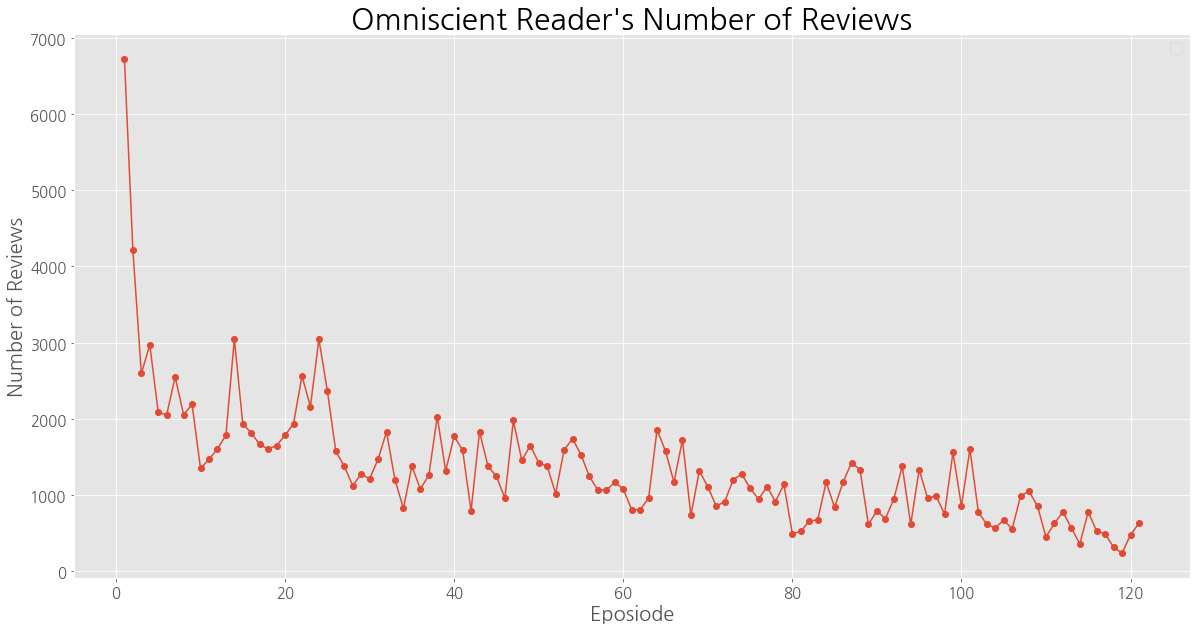

In [102]:
lang = 'en'
show_num_reviews(df,lang, filepath)